# <strong>Retina Disease Classification</strong>
In Opthalmology, there are a plethora of diseases and disorders. When a patient comes to a doctor for a consultation, there are too many diseases to map the symptoms to. In other words, the search space is too huge and at times it might lead to a patients being subject to treatment for a disease which he/she did not actually have. Hence the aim of this notebook is to make an attempt to leverage the power of state of the art CNNs for Multilabel classification of retinal fundus images. Moreover, we generally prefer on getting another perceptive to the disease diagnosis which is implemented as a part of Deep Ensemble Learning. Finally, the problem statement for the work is defined as below.
>"Multilabel Classification of Retinal Diseases using Deep Ensemble Learning to built a system to help reduce the search space for the disease diagnosis in Opthalmology reducing the chances of misdiagnosis."

The architecture aimed to built comprises two classifiers: 
- Binary Classifier to classify whether the eye is infected or not.
- Multilabel Classifier to provide the most probable diseases the retinal image is susceptible to.

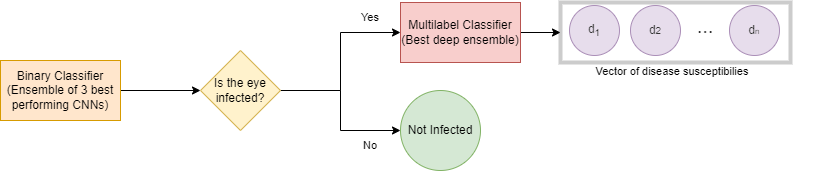

# Importing required modules

In [17]:
# Modules required for data handling and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid")

# Modules required for accessing the file system.
import os

# Modules used for model training and transfer learning
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as cnns
from tensorflow.keras import Model

# Modules used for model evaluation and selection.
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve

# Disabling logging
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Constants
TRAIN_CSV_DIR = "/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/RFMiD_Training_Labels.csv"
TEST_CSV_DIR = "/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/RFMiD_Testing_Labels.csv"
VAL_CSV_DIR = "/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv"

In [18]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
import tensorflow as tf
tf.test.is_gpu_available()

True

# Exploratory Data Analysis

Since, there are too many classes there is a chance of class imbalance to verify it we analyse the class distribution.

In [20]:
train_labels = pd.read_csv(TRAIN_CSV_DIR)
test_labels = pd.read_csv(TEST_CSV_DIR)
val_labels = pd.read_csv(VAL_CSV_DIR)

In [21]:
train_labels.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The dataset has an ID mapped with the filename of the Image, a column for representing whether the retina image is infected or not, and finally a set of 45 disease classes with binary values.

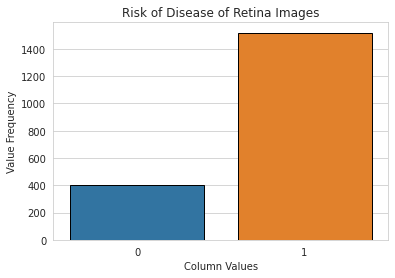

In [22]:
disease_risk_col = dict(train_labels["Disease_Risk"].value_counts())
col_labels = list(disease_risk_col.keys())
label_freq = list(disease_risk_col.values())
sns.barplot(x = col_labels,
            y = label_freq,
            edgecolor = "black")
plt.title("Risk of Disease of Retina Images")
plt.xlabel("Column Values")
plt.ylabel("Value Frequency")
plt.show()

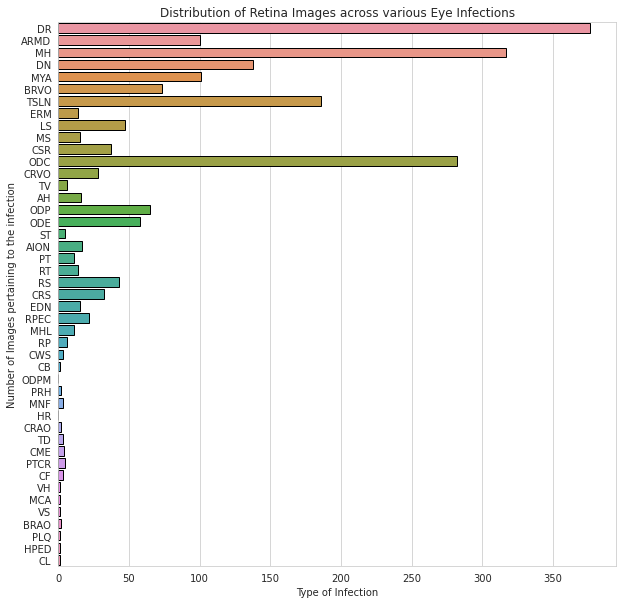

In [23]:
infected_retinas = dict(train_labels.drop(["ID", "Disease_Risk"], axis=1).sum())
retina_infections = list(infected_retinas.keys())
infection_freq = list(infected_retinas.values())
plt.figure(figsize = (10,10))
sns.barplot(y = retina_infections,
            x = infection_freq,
            edgecolor = "black",
            orient = "h")
plt.title("Distribution of Retina Images across various Eye Infections")
plt.xlabel("Type of Infection")
plt.ylabel("Number of Images pertaining to the infection")
plt.show()

From the class distribution we can make the following inferences:
- The diseases OPDM and HR have no samples for training and hence will be dropped. 
- The aim of the model is to predict different diseases so for multilabel classification, Disease Risk column is not relevant. However, we can built a binary classifier for predicting whether the retinal image poses a risk of any disease or not. Based on the outcome of the binary classifier, we will use the multilabel classifier.
- We also observe that there is a lot of class imbalance and hence, for classes below a certain threshold we will consider them into a category of "Other" category or to separate those classes and perform few shot learning on them.

# Training a binary classifier for Disease Risk Feature

At first we need to create the path from the ID attribute for the CSV files for each of three data splits: train, validation, and test.

In [24]:
TRAIN_IMG_DIR="/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training"
TEST_IMG_DIR = "/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test"
VAL_IMG_DIR = "/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation"
def id_to_path(id : int, IMG_DIR : str):
    return os.path.join(IMG_DIR, str(id) + ".png")

In [25]:
train_labels["IMG_DIR"] = TRAIN_IMG_DIR
train_labels["IMG_DIR"] = train_labels.apply(lambda x: id_to_path(x.ID, x.IMG_DIR), 
                                             axis=1)
test_labels["IMG_DIR"] = TEST_IMG_DIR
test_labels["IMG_DIR"] = test_labels.apply(lambda x: id_to_path(x.ID, x.IMG_DIR), 
                                           axis=1)
val_labels["IMG_DIR"] = VAL_IMG_DIR
val_labels["IMG_DIR"] = val_labels.apply(lambda x: id_to_path(x.ID, x.IMG_DIR), 
                                         axis=1)

Since, we are experimenting many state of the art CNNs, each of them have a slightly different preprocessing required. Hence, we write a class ImageProcessor which will perform the following operations:
1. Preprocess the images according to the respective CNN being experimented.
2. Reading the images from the respective CSV files.

In [44]:
class ImagePreprocessor:
    def __init__(self, cnn_variant, input_size):
        self.cnn_variant = cnn_variant
        self.train_gen = None
        self.test_gen = None
        self.val_gen = None
        self.input_size = input_size
        
    def create_generators(self):
        self.train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input,
        )

        self.test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )

        self.val_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )
        
    def preprocess(self):
        train_images = self.train_gen.flow_from_dataframe(
              train_labels,
              x_col="IMG_DIR", 
              y_col="Disease_Risk",
              target_size=self.input_size,
              color_mode='rgb',
              batch_size=32,
              class_mode="binary",
              shuffle=False
        )

        val_images = self.val_gen.flow_from_dataframe(
              test_labels,
              x_col="IMG_DIR", 
              y_col="Disease_Risk",
              target_size=self.input_size,
              color_mode='rgb',
              batch_size=32,
              class_mode="binary",
              shuffle=False
        )

        test_images = self.test_gen.flow_from_dataframe(
              val_labels,
              x_col="IMG_DIR", 
              y_col="Disease_Risk",
              color_mode='rgb',
              target_size=self.input_size,
              batch_size=32,
              class_mode="binary",
              shuffle=False
        )

        return train_images, val_images, test_images

In [27]:
train_labels["Disease_Risk"] = train_labels["Disease_Risk"].astype(str)
test_labels["Disease_Risk"] = test_labels["Disease_Risk"].astype(str)
val_labels["Disease_Risk"] = val_labels["Disease_Risk"].astype(str)

Transfer Learning is when a pre-existing model is used directly on a dataset by only training the full connected layers. However, the state-of-art CNNs are designed to extract features from real life objects but the features of the images generated by Image modalities are not normal and need Domain Adaptation. Therefore, the class TransferLearning deals with model development phase for the Binary Classifier. It has following components:
1. Mark some layers as trainable.
2. Adding a fully connected layer based on the classes.
3. Compilation of the model.
4. Model Training.

In [28]:
class TransferLearning:

    def __init__(self, train, val, model) -> None:
        self.train = train
        self.val = val
        self.model = model
        self.history = None
        self.fine_tune_from = 100
        self.INPUT_SIZE = (200,200,3)
    
    def mark_layers_non_trainable(self):
        for layer in self.model.layers[:self.fine_tune_from]:
            layer.trainable = False
        
        for layer in self.model.layers[self.fine_tune_from:]:
            layer.trainable = True
    
    def add_final_layer(self):
        self.x = Flatten()(self.model.output)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(1, activation = 'sigmoid')(self.x)

    def compile_model(self):
        self.model = Model(inputs = self.model.input, 
                           outputs = self.predictions)
        self.model.compile(optimizer='adam', 
                           loss="binary_crossentropy", 
                           metrics=['accuracy',
                                    tf.keras.metrics.AUC(name="auc",from_logits=True),
                                    tf.keras.metrics.FalseNegatives(name="false_negatives"),
                                    tf.keras.metrics.FalsePositives(name="false_positives"),
                                    tf.keras.metrics.Precision(name="precision"),
                                    tf.keras.metrics.Recall(name="recall")])
    
    def train_model(self):
        self.history = self.model.fit(self.train,
                                      batch_size=32, 
                                      epochs=50, 
                                      validation_data=self.val,
                                      callbacks=[
                                        tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            patience=5,
                                            restore_best_weights=True
                                        )
                                     ])

In [45]:
def experiment_model(preprocessing_function, model, input_size):
    preprocessor = ImagePreprocessor(preprocessing_function, input_size)
    preprocessor.create_generators()
    train, val, test = preprocessor.preprocess()
    modelbuilder = TransferLearning(train, val, model)
    modelbuilder.mark_layers_non_trainable()
    modelbuilder.add_final_layer()
    modelbuilder.compile_model()
    modelbuilder.train_model()
    return modelbuilder.model, modelbuilder.history, test

In [30]:
class ModelEvaluator:
    def __init__(self, history, classes : list, model, test, threshold : float):
        self.history = history
        self.model = model
        self.test = test
        self.classes = classes
        self.num_classes = len(self.classes)
        self.predictions = None
        self.t = threshold
    
    def __plot_metric(self, ax, metric: str,train_metric : str, val_metric : str):
        
        ax.plot(self.history.history[train_metric])
        ax.plot(self.history.history[val_metric])
        ax.title.set_text(train_metric + " v/s " + val_metric)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.title())
        ax.legend(['Train','Val'])
    
    def training_history(self):
        rows = 4
        columns = 2
        c = 0
        metrics = ["loss", "accuracy", "auc", "false_negatives", "false_positives", "precision", "recall"]
        fig, axs = plt.subplots(rows, columns,figsize=(15,15))
        for metric in metrics:
            self.__plot_metric(axs[c//columns, c%columns], 
                               metric.replace("_", " ").title(), 
                               metric, "val_"+metric)
            c += 1
        fig.suptitle("Training History of the Model")
        plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.5)
        plt.show()
    
    def __clip_sigmoid_output(self, p : float):
        if p >= self.t:
            return 1
        else:
            return 0
    
    def predict(self):
        self.predictions = self.model.predict(self.test).flatten()
        self.predictions = list(map(self.__clip_sigmoid_output, self.predictions))
    
    def class_report(self):
        sns.heatmap(tf.math.confusion_matrix(self.test.labels, self.predictions, num_classes=2), 
                    annot=True, cmap="crest")
        print(classification_report(self.test.labels, self.predictions, target_names=self.classes))

In [31]:
class ThresholdTuner:
    def __init__(self, model, test):
        self.model = model
        self.test = test
        self.predictions_raw = None
        self.f1_scores = []
    
    def __predict_test(self):
        self.predictions_raw = self.model.predict(self.test).flatten()
    
    def __clip_logits(self, t : float, p : float):
        if p >= t:
            return 1
        else:
            return 0
    
    def __plot_raw_logits(self, ax):
        ax.hist(self.predictions_raw, edgecolor="black")
        ax.title.set_text("Distribution of logits at final layer")
        ax.set_xlabel("Logits")
        ax.set_ylabel("Frequency")
    
    def __tune_threshold_roc_curve(self, ax):
        fpr, tpr, thresholds = roc_curve(self.test.labels, self.predictions_raw)
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
        print('Best Threshold=%f, G-mean=%.3f using ROC curve' % (thresholds[ix], gmeans[ix]))
        ax.plot([0,1], [0,1], linestyle='--', label='No Skill') 
        ax.plot(fpr, tpr, marker='.', label='Logistic') 
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best') 
        # axis labels
        ax.title.set_text("ROC Curve")
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend()
    
    def __tune_threshold_pr_curve(self, ax):
        precision, recall, thresholds = precision_recall_curve(self.test.labels, self.predictions_raw)
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        print('Best Threshold=%f, F-score=%.3f using PR Curve' % (thresholds[ix], fscore[ix]))
        no_skill = np.count_nonzero(self.test.labels == 1) / len(self.test.labels)
        ax.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill') 
        ax.plot(recall, precision, marker='.', label='Logistic') 
        ax.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best') 
        ax.title.set_text("PR Curve")
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend()
    
    def __tune_threshold_grid_search(self, ax):
        self.ts = np.arange(0, 1.0, 0.001)
        for threshold in self.ts:
            pred = list(map(lambda p: self.__clip_logits(threshold, p), 
                            self.predictions_raw))
            self.f1_scores.append(f1_score(self.test.labels, pred))
        
        ax.plot(self.ts, self.f1_scores)
        max_f1_score = max(self.f1_scores)
        max_threshold = self.ts[np.argmax(self.f1_scores)]
        print('Best Threshold=%f, F-score=%.3f using Grid Search' % (max_threshold, max_f1_score))
        ax.plot(max_threshold, max_f1_score, 'ro')
        ax.plot(0.50, self.f1_scores[500], 'go')
        ax.title.set_text("Tuning of the Threshold")
        ax.set_xlabel("Threshold Value")
        ax.set_xlabel("F1 score")
        
    def find_optimal_thresholds(self):
        self.__predict_test()
        rows = 2
        columns = 2
        fig, axs = plt.subplots(rows, columns,figsize=(15,15))
        self.__plot_raw_logits(axs[0,0])
        self.__tune_threshold_roc_curve(axs[0,1])
        self.__tune_threshold_pr_curve(axs[1,0])
        self.__tune_threshold_grid_search(axs[1,1])
        fig.suptitle("Threshold Moving for Imbalanced Classification")
        plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.5)
        plt.show()

# Experimentation of models for Binary Classification

## EfficientNetB4

In [ ]:
efficientnet, history, efficientnet_test = experiment_model(cnns.efficientnet, 
                                                    cnns.efficientnet.EfficientNetB4(include_top=False, 
                                                    input_shape=(200,200,3)))

In [ ]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], efficientnet, efficientnet_test, 0.5)

In [ ]:
me.training_history()
me.predict()

In [ ]:
me.class_report()

In [ ]:
tuner = ThresholdTuner(efficientnet, efficientnet_test)

In [ ]:
tuner.find_optimal_thresholds()

In [ ]:
efficientnet.save("/kaggle/working/efficientnetB4")

## EfficientNetB0

In [32]:
efficientnet, history, efficientnet_test = experiment_model(cnns.efficientnet, 
                                                    cnns.efficientnet.EfficientNetB0(include_top=False, 
                                                    input_shape=(200,200,3)))

16719872/16705208 [==============================] - 0s 0us/step
Found 1920 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Epoch 1/50
60/60 [==============================] - 384s 6s/step - loss: 2.4000 - accuracy: 0.7578 - auc: 0.6978 - false_negatives: 91.0000 - false_positives: 374.0000 - precision: 0.7925 - recall: 0.9401 - val_loss: 0.3305 - val_accuracy: 0.7906 - val_auc: 0.9286 - val_false_negatives: 0.0000e+00 - val_false_positives: 134.0000 - val_precision: 0.7906 - val_recall: 1.0000
Epoch 2/50
60/60 [==============================] - 310s 5s/step - loss: 0.3634 - accuracy: 0.7911 - auc: 0.8586 - false_negatives: 0.0000e+00 - false_positives: 401.0000 - precision: 0.7911 - recall: 1.0000 - val_loss: 0.3119 - val_accuracy: 0.7906 - val_auc: 0.9246 - val_false_negatives: 0.0000e+00 - val_false_positives: 134.0000 - val_precision: 0.7906 - val_recall: 1.0000

In [33]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], efficientnet, efficientnet_test, 0.5)

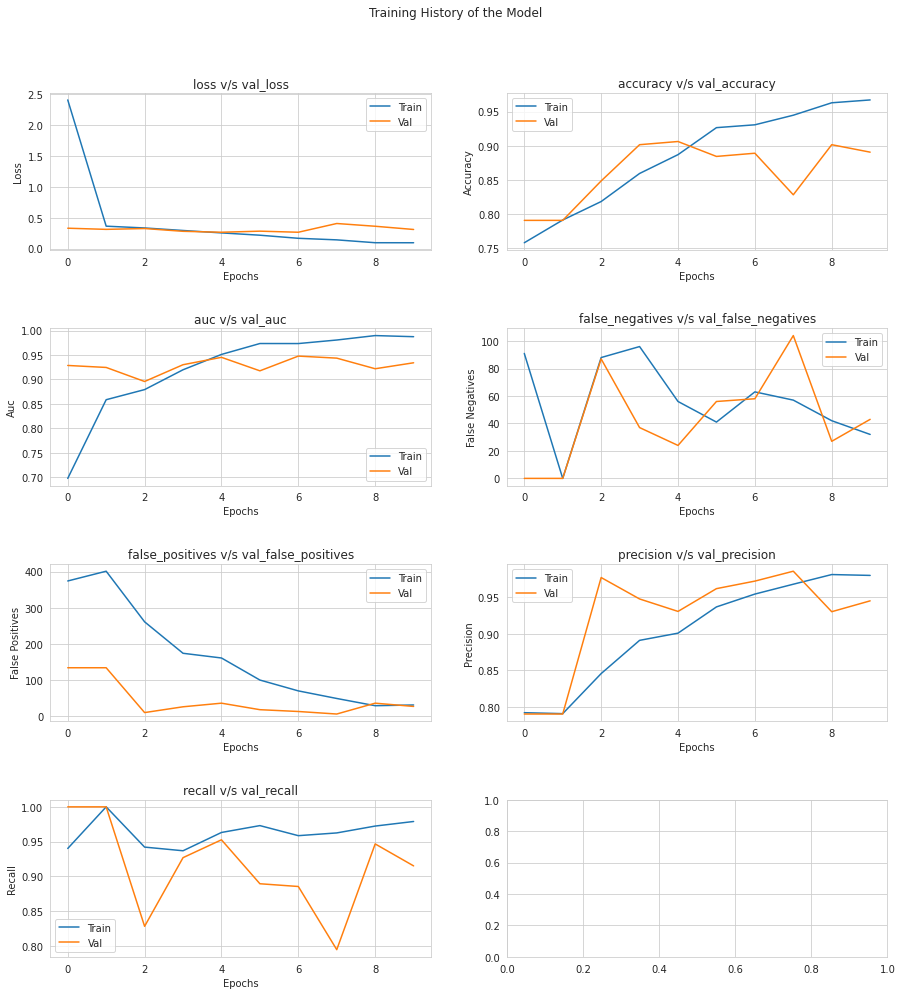

In [34]:
me.training_history()
me.predict()

              precision    recall  f1-score   support

Not Infected       0.68      0.43      0.52       134
    Infected       0.86      0.95      0.90       506

    accuracy                           0.84       640
   macro avg       0.77      0.69      0.71       640
weighted avg       0.82      0.84      0.82       640



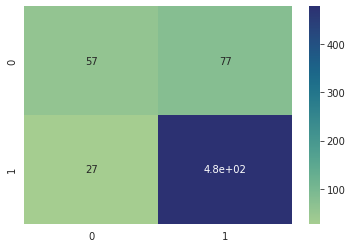

In [35]:
me.class_report()

In [36]:
tuner = ThresholdTuner(efficientnet, efficientnet_test)

Best Threshold=0.857725, G-mean=0.850 using ROC curve
Best Threshold=0.581953, F-score=0.914 using PR Curve
Best Threshold=0.575000, F-score=0.914 using Grid Search


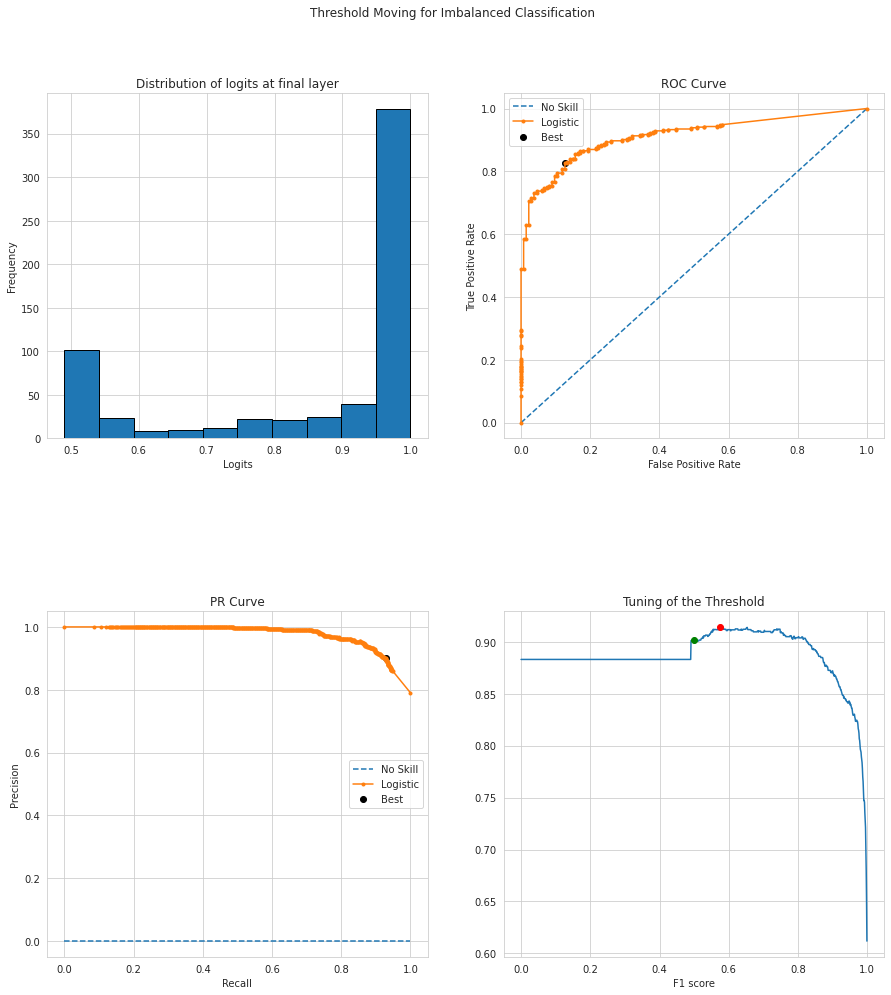

In [37]:
tuner.find_optimal_thresholds()

In [38]:
efficientnet.save("/kaggle/working/efficientnetb0")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# NASNetLarge

In [50]:
nasnet, history, nasnet_test = experiment_model(cnns.nasnet, 
                                                cnns.nasnet.NASNetMobile(include_top=False, 
                                                    input_shape=(224,224,3),
                                                    weights='imagenet'),
                                                (224,224))

20004864/19993432 [==============================] - 0s 0us/step
Found 1920 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Epoch 1/50
60/60 [==============================] - 330s 5s/step - loss: 4.1721 - accuracy: 0.7453 - auc: 0.5571 - false_negatives: 129.0000 - false_positives: 360.0000 - precision: 0.7943 - recall: 0.9151 - val_loss: 1.1280 - val_accuracy: 0.7906 - val_auc: 0.5000 - val_false_negatives: 0.0000e+00 - val_false_positives: 134.0000 - val_precision: 0.7906 - val_recall: 1.0000
Epoch 2/50
60/60 [==============================] - 291s 5s/step - loss: 0.3969 - accuracy: 0.7891 - auc: 0.8192 - false_negatives: 60.0000 - false_positives: 345.0000 - precision: 0.8088 - recall: 0.9605 - val_loss: 1.0505 - val_accuracy: 0.7906 - val_auc: 0.5224 - val_false_negatives: 0.0000e+00 - val_false_positives: 134.0000 - val_precision: 0.7906 - val_recall: 1.0000
E

In [51]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], nasnet, nasnet_test, 0.5)

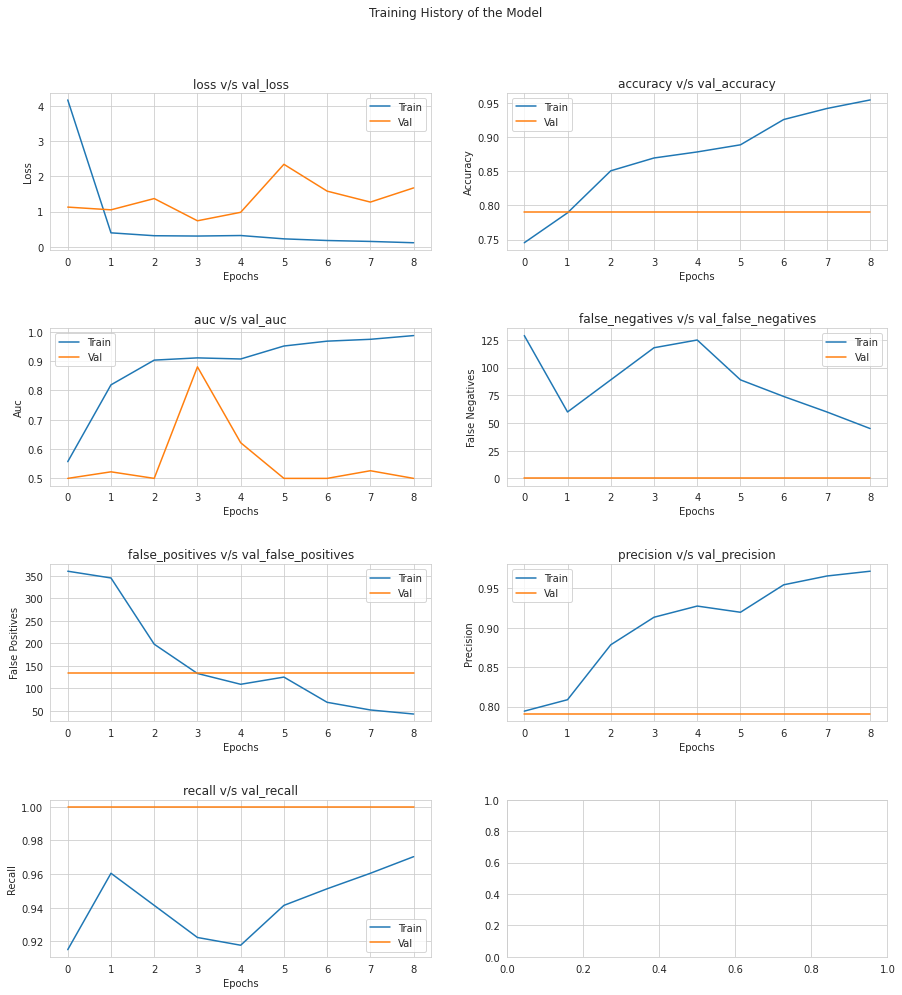

In [52]:
me.training_history()
me.predict()

              precision    recall  f1-score   support

Not Infected       0.00      0.00      0.00       134
    Infected       0.79      1.00      0.88       506

    accuracy                           0.79       640
   macro avg       0.40      0.50      0.44       640
weighted avg       0.63      0.79      0.70       640



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


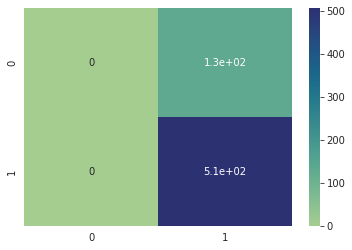

In [53]:
me.class_report()

In [54]:
tuner = ThresholdTuner(nasnet, nasnet_test)

Best Threshold=0.986500, G-mean=0.824 using ROC curve
Best Threshold=0.977528, F-score=0.905 using PR Curve
Best Threshold=0.976000, F-score=0.903 using Grid Search


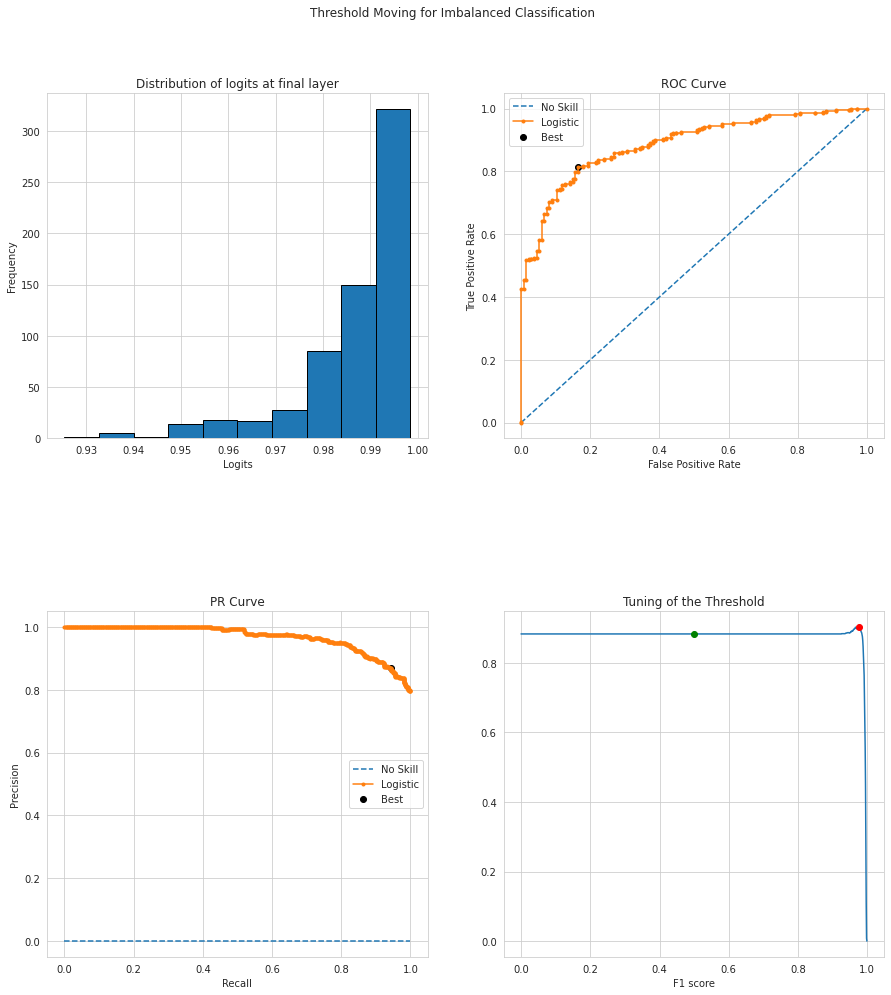

In [55]:
tuner.find_optimal_thresholds()

In [56]:
nasnet.save("/kaggle/working/nasnetmobile")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


              precision    recall  f1-score   support

Not Infected       0.69      0.42      0.52       134
    Infected       0.86      0.95      0.90       506

    accuracy                           0.84       640
   macro avg       0.78      0.68      0.71       640
weighted avg       0.83      0.84      0.82       640



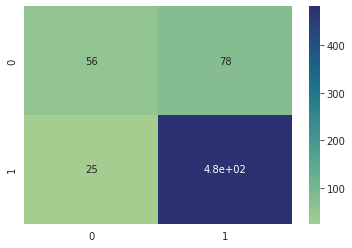

In [58]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], nasnet, nasnet_test, 0.976)
me.predict()
me.class_report()

# VGGNet

In [ ]:
vgg, history, vgg_test = experiment_model(cnns.vgg16, 
                                        cnns.vgg16.VGG16(include_top=False, 
                                        input_shape=(200,200,3)))

In [ ]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], vgg, vgg_test, 0.5)

In [ ]:
me.training_history()
me.predict()

In [ ]:
me.class_report()

In [ ]:
tuner = ThresholdTuner(vgg, vgg_test)

In [ ]:
tuner.find_optimal_thresholds()

In [ ]:
vgg.save("/kaggle/working/vgg16")

# ResNet152

In [ ]:
resnet, history, resnet_test = experiment_model(cnns.resnet, 
                                        cnns.resnet.ResNet152(include_top=False, 
                                        input_shape=(200,200,3)))

In [ ]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], resnet, resnet_test, 0.5)

In [ ]:
me.training_history()
me.predict()

In [ ]:
me.class_report()

In [ ]:
tuner = ThresholdTuner(resnet, resnet_test)

In [ ]:
tuner.find_optimal_thresholds()

In [ ]:
resnet.save("/kaggle/working/resnet152")